<a href="https://colab.research.google.com/github/shrnik/csci6515_nlu/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import normalize


In [ ]:
def read_google_drive_txt(share_link):
    response = requests.get(share_link, stream=True)
    response.raise_for_status()
    file_content = response.content.decode("utf-8")
    return file_content

driveLink = "https://drive.google.com/uc?export=download&id=1dRbJg_tP5lV5laDgp-0J0zN3f15EI-I5"
brownTxt = read_google_drive_txt(driveLink)

analogiesLink = "https://drive.google.com/uc?export=download&id=1jcJV9U3-Pz4F04D2Tg4W50q1tE1ybY3N"
analogiesTxt = read_google_drive_txt(analogiesLink)


In [ ]:
brownArray = np.array(brownTxt.split())
brownArray = np.char.lower(brownArray)
word_counts = Counter(brownArray)
vocab = [word for word, _ in word_counts.most_common(1000)]
term_term_matrix = pd.DataFrame(0, index=vocab, columns=word_counts.keys())

word_to_index = {word: i for i, word in enumerate(vocab)}
term_term_matrix.head()


,the,fulton,county,grand,jury,said,friday,an,investigation,of,...,copies,evaluate,pre-school,grassroots,prepares,displays,booklists,brochures,publishes,newsletter
the,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
",",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
of,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
and,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create Term-term matrix

In [ ]:
k=2
for i, word in enumerate(brownArray):
    if word in word_to_index:
        start, end = max(0, i - k), min(len(brownArray), i + k + 1)
        context_words = brownArray[start:end]

        #remove itself only at ith index
        context_words = np.delete(context_words, i - start)


        for context_word in context_words:
            if context_word != word:
                term_term_matrix.loc[word, context_word] += 1


In [ ]:
term_term_matrix.head()

,the,fulton,county,grand,jury,said,friday,an,investigation,of,...,copies,evaluate,pre-school,grassroots,prepares,displays,booklists,brochures,publishes,newsletter
the,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
",",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
of,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
and,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
term_term_matrix.shape

(1000, 13082)

In [ ]:
zero_count = (term_term_matrix == 0).sum().sum()
totalElements = term_term_matrix.shape[0] * term_term_matrix.shape[1]
print(zero_count)
print(totalElements)
print(zero_count/totalElements)

12951920
13082000
0.99005656627427


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(word, tt_matrix):
    if word not in tt_matrix.index:
        print(f"'{word}' not in vocabulary!")
        return None

    word_vector = tt_matrix.loc[word].values.reshape(1, -1)

    similarity_scores = cosine_similarity(word_vector, tt_matrix.values)[0]

    similarity_df = pd.DataFrame({'word': tt_matrix.index, 'cosine_similarity': similarity_scores})
    similarity_df = similarity_df.sort_values(by='cosine_similarity', ascending=False)

    return similarity_df

similarity_df = get_cosine_similarity("president", term_term_matrix)
similarity_df.head(21)


,word,cosine_similarity
66,president,1.000000
62,state,0.920733
7,in,0.901457
100,most,0.883378
133,administration,0.882241
190,jury,0.882145
112,government,0.881620
86,city,0.879446
464,yankees,0.878806
969,nation,0.878095


In [ ]:
co_matrix_normalized = normalize(term_term_matrix, axis=1, norm='l2')
cosine_sim_matrix = co_matrix_normalized @ co_matrix_normalized.T
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=term_term_matrix.index, columns=term_term_matrix.index)
cosine_sim_df.head()

zero_sim_df = cosine_sim_df[(cosine_sim_df < 0.1)]
zero_sim_df = zero_sim_df.stack().sort_values(ascending=False)
zero_sim_df.to_csv("zero_sim_df.csv")


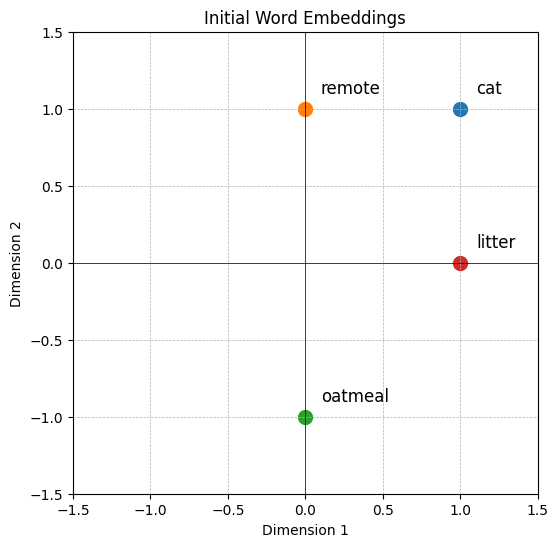

In [ ]:
import matplotlib.pyplot as plt

embeddings = {
    "cat": [1, 1],
    "remote": [0, 1],
    "oatmeal": [0, -1],
    "litter": [1, 0]
}

labels = list(embeddings.keys())
x_vals = [v[0] for v in embeddings.values()]
y_vals = [v[1] for v in embeddings.values()]

# Plot vectors
plt.figure(figsize=(6, 6))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', linewidth=0.5)

for label, x, y in zip(labels, x_vals, y_vals):
    plt.scatter(x, y, label=label, s=100)
    plt.text(x + 0.1, y + 0.1, label, fontsize=12)

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Initial Word Embeddings")
plt.show()

In [ ]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def score(c, w):
  return sigmoid(np.dot(c, w))

def loss(w, c_pos, c_neg_list):
  loss = 0
  pos_score = score(c_pos, w)
  loss += -math.log(pos_score)
  for c_neg in c_neg_list:
    neg_score = score(c_neg, w)
    loss += -math.log(1 - neg_score)
  return loss

def gradientDescentUpdate(w, c_pos, c_neg_list, lr = 1):
  pos_score = score(c_pos, w)
  grad_pos = (pos_score-1) * w
  c_pos -= lr * grad_pos
  w -= lr * ((pos_score - 1) * c_pos)

  for c_neg in c_neg_list:
    neg_score = score(c_neg, w)
    grad_neg = (neg_score) * w
    c_neg -= lr * grad_neg
    w -= lr * (neg_score * c_neg)

  return w, c_pos, c_neg_list

w_cat = np.array([1.0, 1.0])
c_litter = np.array([1.0, 0.0])
c_remote = np.array([0.0, 1.0])
c_oatmeal = np.array([0.0, -1.0])

print("Initial w_cat:", w_cat)
print("Initial loss", loss(w_cat, c_litter, [c_remote, c_oatmeal]))
print("Initial litter category:", c_litter, score(c_litter, w_cat))
print("Initial remote category:", c_remote, score(c_remote, w_cat))
print("Initial oatmeal category:", c_oatmeal, score(c_oatmeal, w_cat))

w_cat, c_litter, [c_remote, c_oatmeal] = gradientDescentUpdate(w_cat, c_litter, [c_remote, c_oatmeal])

print("Updated w_cat:", w_cat)
print("updated loss", loss(w_cat, c_litter, [c_remote, c_oatmeal]))
print("Updated c_litter:", c_litter, score(c_litter, w_cat))
print("Updated c_remote:", c_remote, score(c_remote, w_cat))
print("Updated c_oatmeal:", c_oatmeal, score(c_oatmeal, w_cat))

Initial w_cat: [1. 1.]
Initial loss 1.9397850625546684
Initial litter category: [1. 0.] 0.7310585786300049
Initial remote category: [0. 1.] 0.7310585786300049
Initial oatmeal category: [ 0. -1.] 0.2689414213699951
Updated w_cat: [2.25454705 1.2816069 ]
updated loss 0.2179711799347539
Updated c_litter: [1.26894142 0.26894142] 0.961043173708337
Updated c_remote: [-0.99930003  0.20107199] 0.11970004858100468
Updated c_oatmeal: [-0.59329044 -1.26240621] 0.04947675236113446


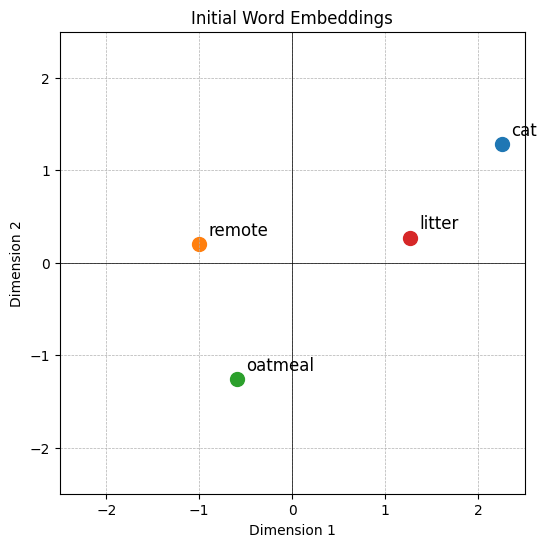

In [ ]:
labels = list(embeddings.keys())
updated_embeddings = [w_cat, c_remote, c_oatmeal, c_litter ]
new_x_vals = [v[0] for v in updated_embeddings]
new_y_vals = [v[1] for v in updated_embeddings]


plt.figure(figsize=(6, 6))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', linewidth=0.5)

for label, x, y in zip(labels, new_x_vals, new_y_vals):
    plt.scatter(x, y, label=label, s=100)
    plt.text(x + 0.1, y + 0.1, label, fontsize=12)

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Word Embeddings after 1 update")
plt.show()


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-02-20 21:47:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-20 21:47:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-20 21:47:15--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 55.1 MB/s eta 0:00:00


In [ ]:
def load_glove_to_dataframe(filepath, embedding_dim=100):
    data = []

    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=np.float32)
            data.append([word, vector])
    df = pd.DataFrame(data, columns=["word", "vector"])
    return df

glove_path = "glove.6B.100d.txt"
df_glove = load_glove_to_dataframe(glove_path, embedding_dim=100)

print(f"✅ Loaded {len(df_glove)} word vectors.")
print(df_glove.head())

✅ Loaded 400000 word vectors.
  word                                             vector
0  the  [-0.038194, -0.24487, 0.72812, -0.39961, 0.083...
1    ,  [-0.10767, 0.11053, 0.59812, -0.54361, 0.67396...
2    .  [-0.33979, 0.20941, 0.46348, -0.64792, -0.3837...
3   of  [-0.1529, -0.24279, 0.89837, 0.16996, 0.53516,...
4   to  [-0.1897, 0.050024, 0.19084, -0.049184, -0.089...


In [ ]:
import faiss
word_vectors = np.vstack(df_glove["vector"].values).astype(np.float32)

# res = faiss.StandardGpuResources()

gpu_index = faiss.IndexFlatIP(word_vectors.shape[1])
# gpu_index = faiss.index_cpu_to_gpu(res, 0, gpu_index)  # Move to GPU

gpu_index.add(word_vectors)


In [ ]:
def search_similar_words(query_word, top_k=5):
    query_row = df_glove[df_glove["word"] == query_word]

    if query_row.empty:
        return f"'{query_word}' not found in vocabulary."

    query_vector = np.array([query_row["vector"].values[0]], dtype=np.float32)

    # Perform search on FAISS GPU index
    distances, indices = gpu_index.search(query_vector, top_k)

    similar_words = df_glove.iloc[indices[0]]["word"].tolist()
    return similar_words

In [ ]:
def search_similar_words_in_vocab(query_word, top_k=5):

    df_glove_vocab = df_glove[df_glove["word"].isin(vocab)]
    query_row = df_glove[df_glove["word"] == query_word]
    if query_row.empty:
        print(f"Word '{query_word}' not found in the vocabulary.")
        return pd.DataFrame(columns=["word", "cosine_similarity"])
    query_vector = np.stack(query_row["vector"].values)[0]
    vocab_vectors = np.stack(df_glove_vocab["vector"].values)
    similarity_scores = cosine_similarity([query_vector], vocab_vectors)[0]


    similarity_df = pd.DataFrame({'word': df_glove_vocab["word"].values, 'cosine_similarity': similarity_scores})


    similarity_df = similarity_df.sort_values(by='cosine_similarity', ascending=False)
    return similarity_df.head(top_k)



In [ ]:
query = "president"
top_k = 21
search_similar_words_in_vocab(query, top_k)

,word,cosine_similarity
84,president,1.000000
617,vice,0.828760
148,former,0.706094
527,chairman,0.692870
424,secretary,0.685858
303,leader,0.683786
73,government,0.682631
207,general,0.679818
257,chief,0.678723
404,administration,0.676365


In [ ]:
def find_analogy(word_a, word_b, word_c, top_k=1):

    row_a = df_glove[df_glove["word"] == word_a.lower()]
    row_b = df_glove[df_glove["word"] == word_b.lower()]
    row_c = df_glove[df_glove["word"] == word_c.lower()]

    if row_a.empty or row_b.empty or row_c.empty:
        return f"one of the ({word_a}, {word_b}, {word_c}) is not in vocabulary."

    vec_a = row_a["vector"].values[0]
    vec_b = row_b["vector"].values[0]
    vec_c = row_c["vector"].values[0]

    query_vector = np.expand_dims(vec_b - vec_a + vec_c, axis=0)

    distances, indices = gpu_index.search(query_vector, top_k+3)
    results = [df_glove.iloc[i]["word"] for i in indices[0] if df_glove.iloc[i]["word"] not in {word_a, word_b, word_c}]

    return results[:top_k] if results else None

In [ ]:
test_analogies = [
     ("doctor", "hospital", "teacher", "school"),
    ("chef", "restaurant", "pilot", "airplane"),
    ("actor", "theater", "soldier", "army"),
    ("artist", "gallery", "scientist", "laboratory"),
    ("writer", "library", "lawyer", "courtroom"),
    ("engineer", "office", "farmer", "farm"),
    ("doctor", "hospital", "dancer", "stage"),
    ("chef", "restaurant", "actor", "theater"),
    ("photographer", "studio", "librarian", "library"),
    ("mechanic", "garage", "carpenter", "workshop")
]

correct = 0
total = len(test_analogies)

for a, b, c, expected in test_analogies:
    predicted = find_analogy(a, b, c, top_k=3)  # Our FAISS analogy function
    print(a,b,c,expected,predicted, )
    if predicted and expected == predicted[0]:
        print("✅ Correct!")
        correct += 1
    else:
        print("❌ Incorrect!")

accuracy = correct / total * 100
print(f"analogy accuracy: {accuracy:.2f}% ({correct}/{total} correct)")

doctor hospital teacher school ['school', 'university', 'college']
✅ Correct!
chef restaurant pilot airplane ['plane', 'helicopter', 'flight']
❌ Incorrect!
actor theater soldier army ['army', 'soldiers', 'troops']
✅ Correct!
artist gallery scientist laboratory ['laboratory', 'university', 'institute']
✅ Correct!
writer library lawyer courtroom ['court', 'federal', 'office']
❌ Incorrect!
engineer office farmer farm ['house', 'government', 'party']
❌ Incorrect!
doctor hospital dancer stage ['ballet', 'theatre', 'dance']
❌ Incorrect!
chef restaurant actor theater ['actress', 'movie', 'film']
❌ Incorrect!
photographer studio librarian library ['library', 'studios', 'choir']
✅ Correct!
mechanic garage carpenter workshop ['brick', 'album', 'rock']
❌ Incorrect!
analogy accuracy: 40.00% (4/10 correct)


In [ ]:
analogies = analogiesTxt.splitlines()
categoryAnalogies = {}
l = len(analogies)

category_name = ""
for a in analogies:
    if a.startswith(":"):
        category_name = a[1:].strip()
        categoryAnalogies[category_name] = []
    else:
      categoryAnalogies[category_name].append(a.split())

In [ ]:
totalProcessed = 0
correctAnalogies = {}
correctAnalogies_topk_3 = {}

for category in categoryAnalogies.keys():
    cat_analogies = categoryAnalogies[category]
    correctAnalogies[category] = 0
    correctAnalogies_topk_3[category] = 0
    for i in cat_analogies:
        totalProcessed+=1
        if correctAnalogies[category] % 10 == 0 : print(totalProcessed)
        a,b,c,expected = i[0], i[1], i[2], i[3]
        predicted = find_analogy(a, b, c, top_k=3)
        if predicted and expected.lower() == predicted[0]:
            correctAnalogies[category] += 1
        if predicted and expected.lower() in predicted:
            correctAnalogies_topk_3[category] += 1
        else:
            print("Incorrect!")





Streaming output truncated to the last 5000 lines.
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
9507
Incorrect!
9508
Incorrect!
9509
9510
Incorrect!
9511
Incorrect!
9512
Incorrect!
9513
Incorrect!
9514
Incorrect!
9515
Incorrect!
9516
9517
Incorrect!
9518
Incorrect!
9519
Incorrect!
9520
9521
Incorrect!
9522
Incorrect!
9523
Incorrect!
9524
9525
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorrect!
Incorre

In [ ]:
category_counts = {}
category_accuracy= {}
category_accuracy_topk_3 = {}
for cat in categoryAnalogies.keys():
    cat_analogies = categoryAnalogies[cat]
    category_counts[cat] = len(cat_analogies)
    category_accuracy[cat] = correctAnalogies[cat] / category_counts[cat] * 100
    category_accuracy_topk_3[cat] = correctAnalogies_topk_3[cat] / category_counts[cat] * 100

In [ ]:
print(category_accuracy)
print(category_accuracy_topk_3)


{'capital-common-countries': 85.57312252964427, 'capital-world': 69.07603890362512, 'currency': 14.549653579676674, 'city-in-state': 18.078638021888935, 'family': 56.32411067193676, 'gram1-adjective-to-adverb': 8.16532258064516, 'gram2-opposite': 12.192118226600986, 'gram3-comparative': 62.83783783783784, 'gram4-superlative': 41.622103386809265, 'gram5-present-participle': 37.784090909090914, 'gram6-nationality-adjective': 78.36147592245153, 'gram7-past-tense': 25.51282051282051, 'gram8-plural': 57.13213213213213, 'gram9-plural-verbs': 29.770114942528735}
{'capital-common-countries': 95.65217391304348, 'capital-world': 87.15738284703802, 'currency': 20.900692840646652, 'city-in-state': 39.64329144710174, 'family': 67.58893280632411, 'gram1-adjective-to-adverb': 15.32258064516129, 'gram2-opposite': 19.088669950738915, 'gram3-comparative': 78.22822822822822, 'gram4-superlative': 59.62566844919787, 'gram5-present-participle': 56.34469696969697, 'gram6-nationality-adjective': 90.1813633520